# Midterm


# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a ML2023 folder and put all the files under A0 folder, then 'ML2023/A0'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/HW9'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "UTC"
time.tzset()

from pytorch_autograd_and_nn import * # select your function
from a4_helper import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.py') # select your function
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('pytorch_autograd_and_nn.py last edited on %s' % py_edit_time)

!pip install pytorch-lightning --quiet
import pytorch_lightning as pl
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

['val.h5', '93.6.ipynb', 'Train.ipynb', 'TEST.ipynb', 'a4_helper.py', '93.7leaky.ipynb', '92.4.pt', 'hw9.ipynb', '94.ipynb', '92.4.ipynb', 'pytorch_autograd_and_nn.py', '94.2.ipynb', '93.6.pt', '93.7leaky.pt', '94.pt', '93.8.pt', '94.2.pt', 'usefuns', '__pycache__', 'saveNEW.pt', '92.4NEW.ipynb', 'pytorch_autograd_and_nn.ipynb']
Hello from pytorch_autograd_and_nn.py!
pytorch_autograd_and_nn.py last edited on Tue Apr 25 10:36:42 2023
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.1 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from usefuns.utils import reset_seed
from collections import OrderedDict

# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

In [5]:
to_float = torch.float
to_long = torch.long

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


# CIFAR-100 Dataset

In [ ]:
class CIFAR100DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './data'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        self.transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.RandomRotation(15),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
                                                  ])
        
        self.transform_test = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))
                                                  ])

        
    def prepare_data(self):
        # download 
        torchvision.datasets.CIFAR100(self.data_dir, train=True, download=True)
        torchvision.datasets.CIFAR100(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = torchvision.datasets.CIFAR100(self.data_dir, train=True, transform=self.transform_train)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar_test = torchvision.datasets.CIFAR100(self.data_dir, train=False, transform=self.transform_test)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=16, num_workers=2)

In [ ]:
# Init our data pipeline
dm = CIFAR100DataModule(batch_size=128)

# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()

dm.setup()

testloader = dm.test_dataloader()
valloader = dm.val_dataloader()
trainloader = dm.train_dataloader()

100%|██████████| 169001437/169001437 [00:05<00:00, 28293981.50it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Number of class is  100


Index of corresponding label is  17
Figure size is  (3, 32, 32)
Corresponding label is  castle


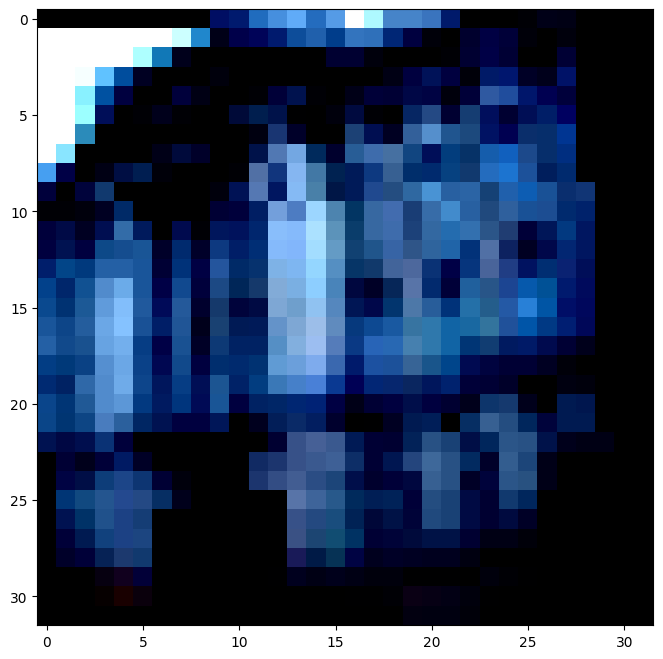

In [ ]:
#function to read files present in the Python version of the dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        myDict = pickle.load(fo, encoding='latin1')
    return myDict

metaData = unpickle('/content/data/cifar-100-python/meta')
label_names = metaData['fine_label_names']
print('Number of class is ', len(label_names))

# get some random test images to see if things are getting displayed correctly
dataiter = iter(trainloader)
images, labels = next(dataiter)
labels_list = labels.tolist()

plt_need_idx = 5
print( 'Index of corresponding label is ', labels_list[plt_need_idx] )
print( 'Figure size is ', images[plt_need_idx].numpy().shape )
print( 'Corresponding label is ', label_names[labels_list[plt_need_idx]] )
plt.imshow(np.transpose(images[plt_need_idx].numpy(), (1, 2, 0)))

# New Train Model (change train_part345 to train_part_NEW)

In [ ]:
def check_accuracy_part_NEW(loader, model):  
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cuda', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cuda', dtype=to_long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc


def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule
  
  Inputs:
  - optimizer: An Optimizer object we will use to train the model
  - lrd: learning rate decay; a factor multiplied at scheduled epochs
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update
  
  Returns: Nothing, but learning rate might be updated
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print('lr decay from {} to {}'.format(param_group['lr'], param_group['lr'] * lrd))
      param_group['lr'] *= lrd


def train_part_NEW(model, optimizer, epochs=1, learning_rate_decay=.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API.
  
  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model
  - epochs: (Optional) A Python integer giving the number of epochs to train for
  
  Returns: Nothing, but prints model accuracies during training.
  """
  model = model.to(device='cuda')  # move the model parameters to CPU/GPU
  num_iters = epochs * len(trainloader)
  print_every = 100
  if verbose:
    num_prints = num_iters // print_every + 1
  else:
    num_prints = epochs
  acc_history = torch.zeros(num_prints, dtype=to_float)
  iter_history = torch.zeros(num_prints, dtype=to_long)
  for e in range(epochs):
    
    adjust_learning_rate(optimizer, learning_rate_decay, e, schedule)
    
    for t, (x, y) in enumerate(trainloader):
      model.train()  # put model to training mode
      x = x.to(device='cuda', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cuda', dtype=to_long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # This is the backwards pass: compute the gradient of the loss with
      # respect to each  parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients
      # computed by the backwards pass.
      optimizer.step()

      tt = t + e * len(trainloader)
      ee = e + 1
      if verbose and (tt % print_every == 0 or (e == epochs-1 and t == len(trainloader)-1)):
        print('Epoch %d, Iteration %d, loss = %.4f' % (ee, tt, loss.item()))
        acc = check_accuracy_part_NEW(valloader, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      elif not verbose and (t == len(trainloader)-1):
        print('Epoch %d, Iteration %d, loss = %.4f' % (ee, tt, loss.item()))
        acc = check_accuracy_part_NEW(valloader, model)
        acc_history[e] = acc
        iter_history[e] = tt
        print()
  torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/HW9/saveNEW.pt")
  print('Save model weight')

  return acc_history, iter_history

# Start Training

In [6]:
def get_resnet(name):
  # YOUR_TURN: Impelement ResNet.__init__ and ResNet.forward
  return ResNet(**networks[name])

networks = {
  'resnet47': {
    'block': PlainBlock,
    'stage_args': [
      (32, 64, 1, False),
      (64, 128, 1, True),
      (128, 256, 2, True),
      (256, 512, 2, True),
    ],
  },
}

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): PlainBlock(
          (net): Sequential(
            (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU()
            (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
    )
    (2): ResNetStage(
      (net): Sequential(
        (0): PlainBlock(
          (net): Sequential(
            (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU()
            (conv1):

In [ ]:
# Init our model
acc_history_dict = {}
iter_history_dict = {}
names = ['resnet47']

name = names[-1]
reset_seed(0)
print(name, '\n')
model = get_resnet(name)
  
# optimizer = optim.SGD(model.parameters(), lr=3e-3)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

torch.cuda.empty_cache()
acc_history, iter_history = train_part_NEW(model, optimizer, epochs=100, schedule=[70, 85, 95], verbose=False)
acc_history_dict[name] = acc_history
iter_history_dict[name] = iter_history

resnet47 

Epoch 1, Iteration 351, loss = 4.2176
Got 233 / 5000 correct (4.66)

Epoch 2, Iteration 703, loss = 4.0869
Got 366 / 5000 correct (7.32)

Epoch 3, Iteration 1055, loss = 3.9567
Got 536 / 5000 correct (10.72)

Epoch 4, Iteration 1407, loss = 3.6037
Got 672 / 5000 correct (13.44)

Epoch 5, Iteration 1759, loss = 3.3241
Got 826 / 5000 correct (16.52)

Epoch 6, Iteration 2111, loss = 3.2033
Got 943 / 5000 correct (18.86)

Epoch 7, Iteration 2463, loss = 3.0107
Got 1031 / 5000 correct (20.62)

Epoch 8, Iteration 2815, loss = 3.1343
Got 1221 / 5000 correct (24.42)

Epoch 9, Iteration 3167, loss = 2.7788
Got 1382 / 5000 correct (27.64)

Epoch 10, Iteration 3519, loss = 2.5499
Got 1464 / 5000 correct (29.28)

Epoch 11, Iteration 3871, loss = 2.0676
Got 1480 / 5000 correct (29.60)

Epoch 12, Iteration 4223, loss = 2.3280
Got 1750 / 5000 correct (35.00)

Epoch 13, Iteration 4575, loss = 2.4600
Got 1882 / 5000 correct (37.64)

Epoch 14, Iteration 4927, loss = 2.0455
Got 1862 / 5000 cor

# Validation Curve

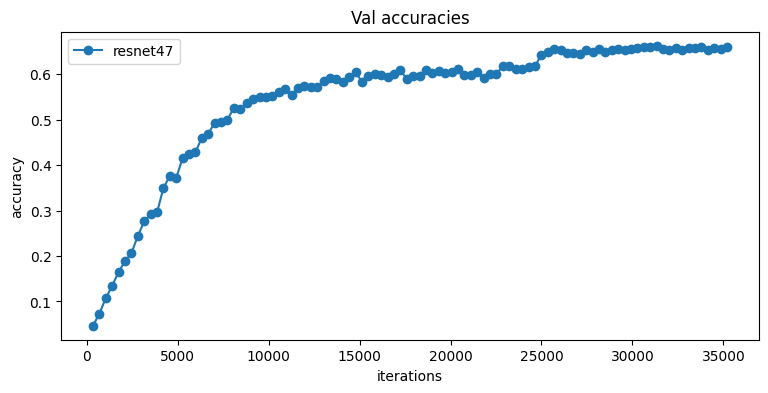

In [ ]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

# Confusion Matrix

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import *

classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale', 
'aquarium' ,'fish', 'ray', 'shark', 'trout', 
'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
'bottles', 'bowls', 'cans', 'cups', 'plates', 
'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers', 
'clock', 'computer keyboard', 'lamp', 'telephone', 'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
'bear', 'leopard', 'lion', 'tiger', 'wolf', 
'bridge', 'castle', 'house', 'road', 'skyscraper', 
'cloud', 'forest', 'mountain', 'plain', 'sea', 
'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo', 
'fox', 'porcupine', 'possum', 'raccoon', 'skunk', 
'crab', 'lobster', 'snail', 'spider', 'worm', 
'baby', 'boy', 'girl', 'man', 'woman', 
'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle', 
'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
'maple', 'oak', 'palm', 'pine', 'willow', 
'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train', 
'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device: ",device)
print(torch.cuda.get_device_name())

def test_label_predictions(model, device, testloader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            prediction = output.argmax(dim=1, keepdim=True)
            actuals.extend(target.view_as(prediction))
            predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

actualsTrain, predictionsTrain = test_label_predictions(model, device, trainloader)
print('Train Dataset Accuracy: %f' % accuracy_score(actualsTrain, predictionsTrain))

actualsVal, predictionsVal = test_label_predictions(model, device, valloader)
print('Val. Dataset Accuracy: %f' % accuracy_score(actualsVal, predictionsVal))

actualsTest, predictionsTest = test_label_predictions(model, device, testloader)
print('Test Dataset Accuracy: %f' % accuracy_score(actualsTest, predictionsTest))

Device:  cuda:0
Tesla T4
Train Dataset Accuracy: 0.981822
Val. Dataset Accuracy: 0.655400
Test Dataset Accuracy: 0.688700


[[84  0  0 ...  0  0  0]
 [ 0 82  0 ...  0  0  0]
 [ 0  0 55 ...  0  2  0]
 ...
 [ 0  0  0 ... 72  0  0]
 [ 0  0  4 ...  0 55  0]
 [ 0  1  1 ...  0  0 69]]


<ipython-input-14-3237678d89e9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + classes)
<ipython-input-14-3237678d89e9>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + classes)


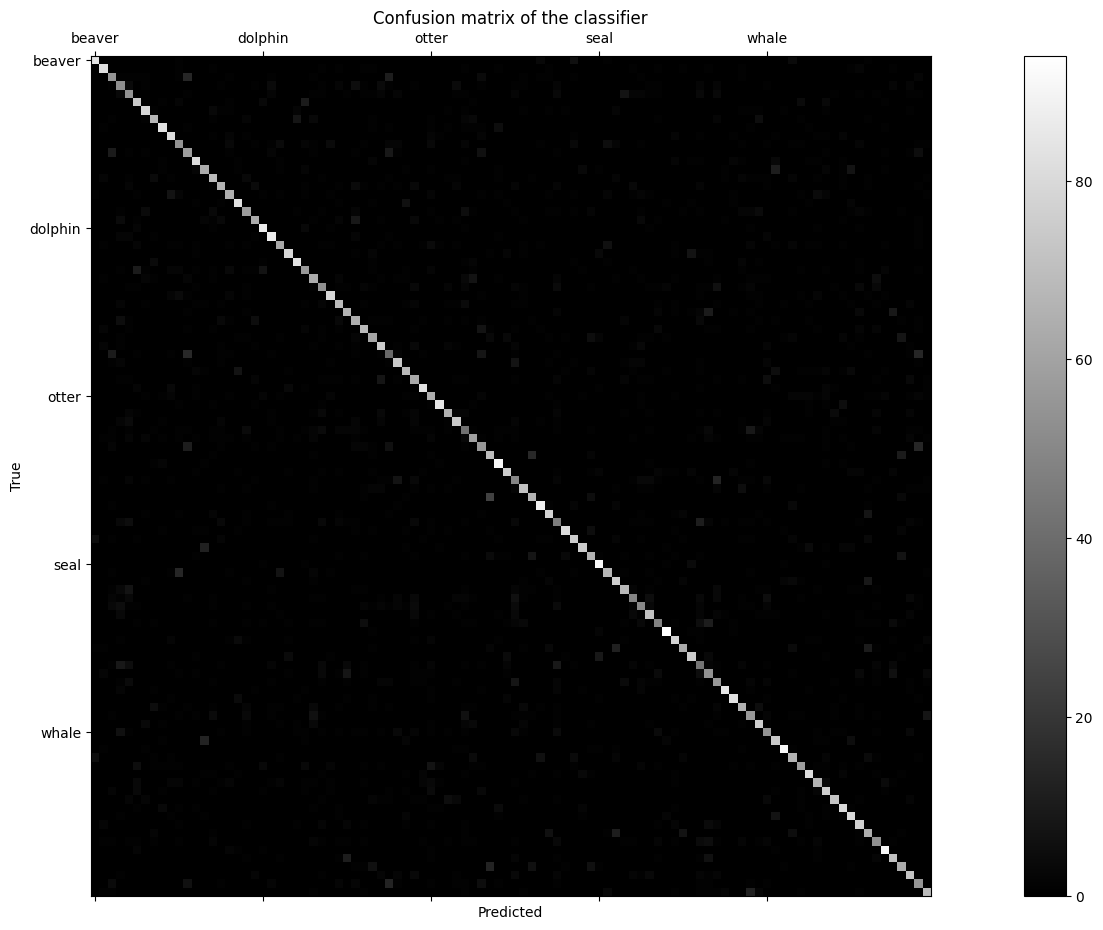

In [ ]:
cm = confusion_matrix(actualsTest, predictionsTest)
print(cm)
fig = plt.figure(figsize=(24,24))
ax = fig.add_subplot(211)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + classes)
ax.set_yticklabels([''] + classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# TEST
1.請將此測試程式碼，全部接續到HW9的最後部分。

2.部分函式定義在HW9作業裡，所以需先執行HW9的函式碼。

3.若要儲存參數，可在"def train_part345"裡，函式定義最後面加上:

torch.save(model.state_dict(), "/content/drive/MyDrive/ML2023/midterm/HW9/saveME.pt")

print('Save model weight')

可參考:https://zhuanlan.zhihu.com/p/82038049


In [8]:
import h5py  
import numpy as np
import torch
from torch.utils.data import Dataset
#############################################################################
# 模型導入
names = ['resnet47']
name = names[-1]
reset_seed(0)
print(name, '\n')
model = get_resnet(name)
model = model.to(device='cuda')
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/HW9/saveNEW.pt')) # 修改成自己的模型權重存檔位置
model.eval()
#############################################################################
# 讀檔
f = h5py.File('/content/drive/MyDrive/Colab Notebooks/HW9/val.h5','r') # 修改成要測試的數據集
Image1 = f['data']
Label1 = f['labels']

# 定義打包類別
class TestDataset(Dataset):
  def __init__(self, data_tensor, target_tensor):
      self.data_tensor = data_tensor
      self.target_tensor = target_tensor
  def __getitem__(self, index):
      return self.data_tensor[index], self.target_tensor[index]
  def __len__(self):
      # return self.data_tensor.size(0)
      return len(self.data_tensor)

# 分割
Num_dataset = 10
Image1_split = np.split(Image1, Num_dataset)
Label1_split = np.split(Label1, Num_dataset)
Image1_tensor = torch.Tensor( Image1_split )
Label1_tensor = torch.Tensor( Label1_split )
data_combine = TestDataset( Image1_tensor, Label1_tensor )

# 預測
num_correct = 0
num_samples = 0
for x, y in data_combine:
  x = x.to(device='cuda', dtype=to_float)  # move to device, e.g. GPU
  y = y.to(device='cuda', dtype=to_long)
  scores = model(x)
  _, preds = scores.max(1)
  num_correct += (preds == y).sum()
  num_samples += preds.size(0)
acc = float(num_correct) / num_samples
print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
#############################################################################
f.close()

resnet47 

Got 942 / 1000 correct (94.20)
